In [250]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [251]:
# Define time parameters
T = 1/60

# Dimensions
road_length = 2.0  # in km
road_width =W= 0.0075  # in km

# Number of grid cells
nx = 100   # along the length of the road
ny = 10 # along the width of the road

# Spatial step sizes
dx = road_length / nx  # spatial step size in km along the length
dy = road_width / ny   # spatial step size in km along the width

# Define constants
#W =0.0075  # Width of the road in km
r_i = {'A': 0.89, 'B': 0.78, 'C': 0.74, 'D': 0.50}
D_A, D_B, D_C, D_D = 0.0000006, 0.0000005, 0.0000004, 0.0000003  # Diffusion coefficients in km^2/h
a_A, a_B, a_C, a_D = 0.0018 * 0.0006, 0.0026 * 0.0014, 0.004 * 0.0016, 0.0065 * 0.0022
# Maximum AO values for each class
AO_max_A, AO_max_B, AO_max_C, AO_max_D = 0.80, 0.78, 0.68, 0.50
# Initialize densities with random values
np.random.seed(0)  # For reproducibility

epsilon = 1e-5

In [252]:
# Target average densities for the different regions
target_density_A = 10
target_density_B = 10
target_density_C = 5
target_density_D = 1

def generate_uniform_density(target_density, shape):#Instead of generating random numbers, we now use np.full to create an array of the given shape filled with the target_density. This directly creates a uniform distribution where all values are equal to the target density.
    """Generates a uniform density field with a specified target density.

    Args:

        target_density: The desired average density.
        shape: The shape of the density field (e.g., (nx, ny)).

    Returns:
        A NumPy array containing the uniform density field.
    """
    uniform_density = np.full(shape, target_density)
    return uniform_density
# Initialize densities with uniform distribution
rho_A = generate_uniform_density(target_density_A, (nx, ny))
rho_B = generate_uniform_density(target_density_B, (nx, ny))
rho_C = generate_uniform_density(target_density_C, (nx, ny))
rho_D = generate_uniform_density(target_density_D, (nx, ny))

In [253]:
# Target average velocities (in km/h)
u_target_A_x, u_target_A_y = 45.0, 2.5
u_target_B_x, u_target_B_y = 42.1, 1.4
u_target_C_x, u_target_C_y = 52.9, 5.6
u_target_D_x, u_target_D_y = 47.2, 4.3
def generate_uniform_velocity(target_velocity_x, target_velocity_y, shape):
    """Generates a uniform velocity field with specified target velocities.

    Args:
        target_velocity_x: The desired average velocity in the x-direction.
        target_velocity_y: The desired average velocity in the y-direction.
        shape: The shape of the velocity field (e.g., (nx, ny)).

    Returns:
        A tuple containing two NumPy arrays:
            - u_x: Uniform velocity field in the x-direction.
            - u_y: Uniform velocity field in the y-direction.
    """
    u_x = np.full(shape, target_velocity_x)
    u_y = np.full(shape, target_velocity_y)
    return u_x, u_y
# Initialize velocity fields with uniform distribution
u_x_A, u_y_A = generate_uniform_velocity(u_target_A_x, u_target_A_y, (nx, ny))
u_x_B, u_y_B = generate_uniform_velocity(u_target_B_x, u_target_B_y, (nx, ny))
u_x_C, u_y_C = generate_uniform_velocity(u_target_C_x, u_target_C_y, (nx, ny))
u_x_D, u_y_D = generate_uniform_velocity(u_target_D_x, u_target_D_y, (nx, ny))


In [254]:
# Calculate flow (Q) directly from density (rho) and velocity (v)
Q_x_A = rho_A * u_x_A
Q_y_A = rho_A * u_y_A
Q_x_B = rho_B * u_x_B
Q_y_B = rho_B * u_y_B
Q_x_C = rho_C * u_x_C
Q_y_C = rho_C * u_y_C
Q_x_D = rho_D * u_x_D
Q_y_D = rho_D * u_y_D

In [255]:
# Initialize AO matrix
AO = a_A * rho_A + a_B * rho_B + a_C * rho_C + a_D * rho_D

In [256]:
# Define inflow values (vehicles per hour)
q_A_inflow = 5
q_B_inflow = 4
q_C_inflow = 3
q_D_inflow = 2

See where the following code is used.

In [257]:
# Determine maximum velocities
u_x_max = max(np.max(u_x_A), np.max(u_x_B), np.max(u_x_C), np.max(u_x_D))
u_y_max = max(np.max(u_y_A), np.max(u_y_B), np.max(u_y_C), np.max(u_y_D))

# Determine maximum diffusion coefficient
D_max = max(D_A, D_B, D_C, D_D)

See if the cfl condition mentioned here is correct cite a paper in your document

In [258]:
# Calculate the time step to satisfy CFL conditions
dt_advection_x = dx / u_x_max
dt_advection_y = dy / u_y_max
dt_diffusion_x = dx**2 / (2 * D_max)
dt_diffusion_y = dy**2 / (2 * D_max)

# Choose the smaller time step to ensure all conditions are satisfied
dt = min(dt_advection_x, dt_advection_y, dt_diffusion_x, dt_diffusion_y)


See how the following code is used

In [259]:
# Calculate number of time steps
time_steps = int(T/dt)
time = np.linspace(0, T, time_steps)

In [260]:
# Define stopping and starting intervals in seconds
stop_interval = 40 / 3600  # Interval in hours (35 seconds)
start_interval = 10 / 3600  # Interval in hours (70 seconds)
#stop_position = 1
def is_stopping(t, stop_interval=stop_interval,start_interval=start_interval):
 #   """Checks if the current time is within a stopping interval."""
  #  cycle_duration = stop_interval + start_interval  # Total duration of one stop-start cycle
   # time_in_cycle = t % cycle_duration  # Time elapsed within the current cycle

   if start_interval <= t < stop_interval+start_interval:
        return True  # Stopping is active
   else:
        return False  # Stopping is inactive
#is_stopping(11/3600)

In [261]:
"""def apply_stopping_behavior_u(u_x, u_y, t):
    if is_stopping(t): #if is stopping function is true
        stopping_region = (np.arange(nx - 50, nx - 25) and  np.arange(ny - 5))
        u_x[stopping_region] = 0
        u_y[stopping_region] = 0
    return u_x, u_y
#np.arange(nx):Creates an array of integers from 0 to nx - 1.
# In this model, velocity is updated based on a predefined equation involving density and maximum velocity. It's treated more as an input to the system influencing the flow, while flow is the variable being calculated and updated using the numerical scheme. so velocity is defined using single variable
def apply_stopping_behavior_f(Q_updated_x, Q_updated_y, t):
    if is_stopping(t): #if is stopping function is true
        stopping_region = (np.arange(nx - 50, nx - 25) and  np.arange(ny - 5))
        Q_updated_x[stopping_region] = 0
        Q_updated_y[stopping_region] = 0
    return Q_updated_x, Q_updated_y"""
def apply_stopping_behavior_u(u_x, u_y, t, dx, dy):
    if is_stopping(t):
        # Compute physical coordinates corresponding to the stopping region
        x_physical = np.arange(nx) * dx  # Convert grid indices to physical x-coordinates
        y_physical = np.arange(ny) * dy  # Convert grid indices to physical y-coordinates

        # Define stopping region in km
        x_min, x_max = 0.5, 1.5  # Vehicles stop between 0.5 km and 1.5 km
        y_min, y_max = 0, W / 2  # Vehicles stop in the first half of the road width

        # Create boolean mask based on physical locations
        stopping_region = np.logical_and.outer(
            (x_physical >= x_min) & (x_physical < x_max),  # x inside [0.5, 1.5] km
            (y_physical >= y_min) & (y_physical < y_max)   # y inside [0, W/2] km
        )
        print("stopping_region shape:", stopping_region.shape)  # Print shape
        print("stopping_region values:", stopping_region)  # Print values

        # Apply stopping behavior
        u_x[stopping_region] = 0
        u_y[stopping_region] = 0

    return u_x, u_y


def apply_stopping_behavior_f(Q_updated_x, Q_updated_y, t,dx,dy):
    if is_stopping(t):
        # Compute physical coordinates corresponding to the stopping region
        x_physical = np.arange(nx) * dx  # Convert grid indices to physical x-coordinates
        y_physical = np.arange(ny) * dy  # Convert grid indices to physical y-coordinates

        # Define stopping region in km
        x_min, x_max = 0.5, 1.5  # Vehicles stop between 0.5 km and 1.5 km
        y_min, y_max = 0, W / 2  # Vehicles stop in the first half of the road width

        # Create boolean mask based on physical locations
        stopping_region = np.logical_and.outer(
            (x_physical >= x_min) & (x_physical < x_max),  # x inside [0.5, 1.5] km
            (y_physical >= y_min) & (y_physical < y_max)   # y inside [0, W/2] km
        )

        # Apply stopping behavior
        Q_updated_x[stopping_region] = 0
        Q_updated_y[stopping_region] = 0

    return Q_updated_x, Q_updated_y


In [262]:
# Function to calculate fluxes using upwind scheme in FVM
def calculate_fluxes_upwind(rho,Q_x, Q_y, u_x, u_y, D, dx, dy, q_inflow):
    # Ensure u_x, u_y, and rho are always > 0
    u_x = np.abs(u_x)
    u_y = np.abs(u_y)

    # Initialize fluxes with Q values
    Q_updated_x = Q_x.copy()  # Use the provided Q_x as the initial flux_x
    Q_updated_y = Q_y.copy()  # Use the provided Q_y as the initial flux_y
    # Distribute inflow uniformly to all rows at the left boundary (x=0)
    inflow = q_inflow/ (W*ny)


    """# Replace denominators that are zero or close to zero with epsilon
    #dx_safe = np.where((np.isclose(dx,0)), epsilon, dx)
    #dy_safe = np.where((np.isclose(dy,0)), epsilon, dy)
    a_safe = np.where((np.isclose(a,0)), epsilon, a)

    # Replace denominators that are zero or close to zero with epsilon
    dx_safe = np.where(dx == 0, epsilon, dx)
    dy_safe = np.where(dy == 0, epsilon, dy)
    a_safe = np.where(a == 0, epsilon, a)"""

    for i in range(1, Q_x.shape[0]-1):
        for j in range(Q_x.shape[1]):
            if i==1:
                Q_updated_x[i,j] = inflow/W

            else:
                Q_updated_x[i, j]=(u_x[i, j] *rho[i,j] )-D*((rho[i+1,j] - (rho[i-1,j])) / (2*(dx + epsilon)))#Using central difference scheme for derivatives
                Q_updated_x[i,j]=max(0,Q_updated_x[i,j])
    # Compute fluxes in the y direction
    for i in range(Q_y.shape[0]-1):
        for j in range(1, Q_y.shape[1]):
            if j==1:
                Q_updated_y[i,j] = 0
            elif j == ny-2:
                Q_updated_y[i,j] = 0
            else:
                Q_updated_y[i,j]= (u_y[i, j] *rho[i,j] )-D*((rho[i+1,j] - (rho[i-1,j])) / (2*(dy + epsilon)))
                Q_updated_y[i,j]=max(0,Q_updated_y[i,j])
    return Q_updated_x, Q_updated_y, Q_updated_x + Q_updated_y
"see before eqn 20 of the last report for the eqn"

'see before eqn 20 of the last report for the eqn'

In [263]:
def update_density_fvm(rho, u_x, u_y, D, q_inflow, dx, dy,Q_x, Q_y, dt):
    #inflow density at the boundary is calculated as the total number of vehicles entering per unit time, distributed uniformly across the width of the road.
    nx, ny = rho.shape
    rho_new = rho.copy()
    Q_updated_x, Q_updated_y, Q = calculate_fluxes_upwind(rho,Q_x, Q_y, u_x, u_y, D, dx, dy, q_inflow)

    # Update density using finite volume method
    for i in range(1, nx-1):
        for j in range(1, ny-1):
          if i==nx-1:
            rho_new[i, j]=0
          else:
            rho_new[i, j] = rho[i, j] - (dt/(2*dx)) * (Q_updated_x[i+1,j] - Q_updated_x[i-1,j]) - (dt/(2*dy)) * (Q_updated_y[i+1,j] - Q_updated_y[i-1,j])
            # Ensure densities remain non-negative
            rho_new[i, j] = np.maximum(rho_new[i, j], 0.00000000001)
    return rho_new

In [264]:
# Specify the location for velocity extraction
x_loc = 0.45  # km
y_loc = road_width / 3  # km

# Find the nearest grid indices to the specified location
x_index = int(round(x_loc / dx))
y_index = int(round(y_loc / dy))


# Extract velocities over time at the specified location
v_A_time = []
v_B_time = []
v_C_time = []
v_D_time = []
time_list=[]

In [265]:
# Define a tolerance for floating-point comparisons
tolerance = 1e-5
plotted_times = set()

# Time-stepping loop
time_points = np.linspace(0, T,20 ) # To visualize at 10 points in time
time_index = 0

<ipython-input-266-885c3bfacbd6>:29: RuntimeWarning: overflow encountered in exp
  u_x_A = u_target_A_x * (1 - np.exp(1 - np.exp(r_i['A'] *( AO_max_A / (AO+epsilon)) - r_i['A'])))
<ipython-input-266-885c3bfacbd6>:30: RuntimeWarning: overflow encountered in exp
  u_y_A = u_target_A_y * (1 - np.exp(1 - np.exp(r_i['A'] * (AO_max_A / (AO+epsilon)) - r_i['A'])))
<ipython-input-266-885c3bfacbd6>:31: RuntimeWarning: overflow encountered in exp
  u_x_B = u_target_B_x * (1 - np.exp(1 - np.exp(r_i['B'] * (AO_max_B / (AO+epsilon)) - r_i['B'])))
<ipython-input-266-885c3bfacbd6>:32: RuntimeWarning: overflow encountered in exp
  u_y_B = u_target_B_y * (1 - np.exp(1 - np.exp(r_i['B'] * (AO_max_B / (AO+epsilon)) - r_i['B'])))
<ipython-input-266-885c3bfacbd6>:33: RuntimeWarning: overflow encountered in exp
  u_x_C = u_target_C_x * (1 - np.exp(1 - np.exp(r_i['C'] * (AO_max_C / (AO+epsilon)) - r_i['C'])))
<ipython-input-266-885c3bfacbd6>:34: RuntimeWarning: overflow encountered in exp
  u_y_C = u_target_

Streaming output truncated to the last 5000 lines.
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ T

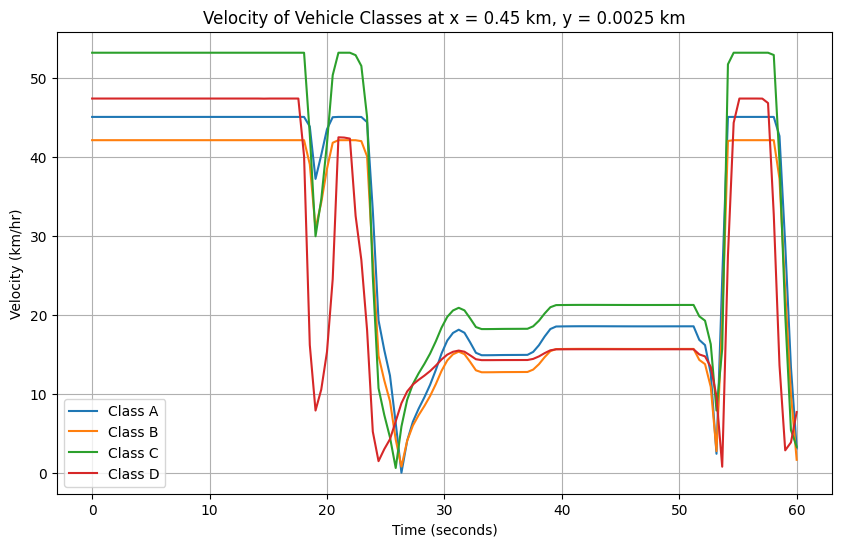

"\n  # Generate 3D contour plots only at specified time points\n    if (abs(t - closest_time) < tolerance and closest_time not in plotted_times and (closest_time == 0 or closest_time == T or abs(t - closest_time) < tolerance)):\n        plotted_times.add(closest_time)\n        #A plot is generated only if t is close to one of the time_points (accounting for floating-point precision).\n#Each time_point is plotted only once.\n#Special cases (start at t=0 and end at t=T) are always handled explicitly and accurately.\n\n        X, Y = np.meshgrid(np.arange(nx) * dx, np.arange(ny) * dy)\n  # Generate 3D contour plots only at specified time points\n    #if any(np.abs(t - tp) < tolerance for tp in time_points):\n       # X, Y = np.meshgrid(np.arange(nx) * dx, np.arange(ny) * dy)\n\n        # Create a new figure for each time step\n        fig = plt.figure(figsize=(24, 18))\n        fig.suptitle(f'Time: {closest_time:.2f} hours')  # Update the title with the current time\n\n        # Density p

In [266]:
# Time-stepping loop
for t in time:
    Q_x_A, Q_y_A, Q_A = calculate_fluxes_upwind(rho_A, Q_x_A, Q_y_A, u_x_A, u_y_A, D_A, dx, dy, q_A_inflow) # Pass q_A_inflow
    Q_x_B, Q_y_B, Q_B = calculate_fluxes_upwind(rho_B, Q_x_B, Q_y_B, u_x_B, u_y_B, D_B, dx, dy, q_B_inflow) # Pass q_B_inflow
    Q_x_C, Q_y_C, Q_C = calculate_fluxes_upwind(rho_C, Q_x_C, Q_y_C, u_x_C, u_y_C, D_C, dx, dy, q_C_inflow) # Pass q_C_inflow
    Q_x_D, Q_y_D, Q_D = calculate_fluxes_upwind(rho_D, Q_x_D, Q_y_D, u_x_D, u_y_D, D_D, dx, dy, q_D_inflow) # Pass q_D_inflow

    Q_x_A, Q_y_A = apply_stopping_behavior_f(Q_x_A, Q_y_A, t,dx,dy)
    Q_x_B, Q_y_B = apply_stopping_behavior_f(Q_x_B, Q_y_B, t,dx,dy)
    Q_x_C, Q_y_C = apply_stopping_behavior_f(Q_x_C, Q_y_C, t,dx,dy)
    Q_x_D, Q_y_D = apply_stopping_behavior_f(Q_x_D, Q_y_D, t,dx,dy)



    # Update densities using FVM with upwind scheme
    # Update densities using FVM with upwind scheme
    rho_A = update_density_fvm(rho_A, u_x_A, u_y_A, D_A, q_A_inflow, dx, dy, Q_x_A, Q_y_A, dt)
    rho_B = update_density_fvm(rho_B,  u_x_B, u_y_B, D_B, q_B_inflow, dx, dy, Q_x_B, Q_y_B, dt)
    rho_C = update_density_fvm(rho_C,  u_x_C, u_y_C, D_C, q_C_inflow, dx, dy, Q_x_C, Q_y_C, dt)
    rho_D = update_density_fvm(rho_D,  u_x_D, u_y_D, D_D, q_D_inflow, dx, dy, Q_x_D, Q_y_D, dt)
    # Recalculate AO

    # Recalculate AO
    AO = a_A * rho_A + a_B * rho_B + a_C * rho_C + a_D * rho_D



    # Update velocities
    u_x_A = u_target_A_x * (1 - np.exp(1 - np.exp(r_i['A'] *( AO_max_A / (AO+epsilon)) - r_i['A'])))
    u_y_A = u_target_A_y * (1 - np.exp(1 - np.exp(r_i['A'] * (AO_max_A / (AO+epsilon)) - r_i['A'])))
    u_x_B = u_target_B_x * (1 - np.exp(1 - np.exp(r_i['B'] * (AO_max_B / (AO+epsilon)) - r_i['B'])))
    u_y_B = u_target_B_y * (1 - np.exp(1 - np.exp(r_i['B'] * (AO_max_B / (AO+epsilon)) - r_i['B'])))
    u_x_C = u_target_C_x * (1 - np.exp(1 - np.exp(r_i['C'] * (AO_max_C / (AO+epsilon)) - r_i['C'])))
    u_y_C = u_target_C_y * (1 - np.exp(1 - np.exp(r_i['C'] * (AO_max_C / (AO+epsilon)) - r_i['C'])))
    u_x_D = u_target_D_x * (1 - np.exp(1 - np.exp(r_i['D'] * (AO_max_D / (AO+epsilon)) - r_i['D'])))
    u_y_D = u_target_D_y * (1 - np.exp(1 - np.exp(r_i['D'] * (AO_max_D / (AO+epsilon)) - r_i['D'])))

    # Apply stopping behavior
    u_x_A, u_y_A = apply_stopping_behavior_u(u_x_A, u_y_A, t,dx,dy)
    u_x_B, u_y_B = apply_stopping_behavior_u(u_x_B, u_y_B, t,dx,dy)
    u_x_C, u_y_C = apply_stopping_behavior_u(u_x_C, u_y_C, t,dx,dy)
    u_x_D, u_y_D = apply_stopping_behavior_u(u_x_D, u_y_D, t,dx,dy)



    # Calculate AO_minus for each category
    #AO_minus_A = AO - a_A * rho_A
    #AO_minus_B = AO - a_B * rho_B
    #AO_minus_C = AO - a_C * rho_C
    #AO_minus_D = AO - a_D * rho_D
    # Update densities using FVM with upwind scheme








    # Calculate velocity magnitudes
    v_A = np.sqrt(u_x_A**2 + u_y_A**2)
    v_B = np.sqrt(u_x_B**2 + u_y_B**2)
    v_C = np.sqrt(u_x_C**2 + u_y_C**2)
    v_D = np.sqrt(u_x_D**2 + u_y_D**2)
    # Append velocities to the lists
    v_A_time.append(np.sqrt(u_x_A[x_index, y_index]**2 + u_y_A[x_index, y_index]**2))
    v_B_time.append(np.sqrt(u_x_B[x_index, y_index]**2 + u_y_B[x_index, y_index]**2))
    v_C_time.append(np.sqrt(u_x_C[x_index, y_index]**2 + u_y_C[x_index, y_index]**2))
    v_D_time.append(np.sqrt(u_x_D[x_index, y_index]**2 + u_y_D[x_index, y_index]**2))
    time_list.append(t * 3600)
  # Plotting the velocities
plt.figure(figsize=(10, 6))
plt.plot(time_list, v_A_time, label='Class A')
plt.plot(time_list, v_B_time, label='Class B')
plt.plot(time_list, v_C_time, label='Class C')
plt.plot(time_list, v_D_time, label='Class D')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (km/hr)')
plt.title(f'Velocity of Vehicle Classes at x = {x_loc} km, y = {y_loc} km')
plt.grid(True)
plt.legend()
plt.show()

#closest_time = min(time_points, key=lambda tp: abs(t - tp))#line is used to find the closest time point from time_points to the current simulation time t
"""
  # Generate 3D contour plots only at specified time points
    if (abs(t - closest_time) < tolerance and closest_time not in plotted_times and (closest_time == 0 or closest_time == T or abs(t - closest_time) < tolerance)):
        plotted_times.add(closest_time)
        #A plot is generated only if t is close to one of the time_points (accounting for floating-point precision).
#Each time_point is plotted only once.
#Special cases (start at t=0 and end at t=T) are always handled explicitly and accurately.

        X, Y = np.meshgrid(np.arange(nx) * dx, np.arange(ny) * dy)
  # Generate 3D contour plots only at specified time points
    #if any(np.abs(t - tp) < tolerance for tp in time_points):
       # X, Y = np.meshgrid(np.arange(nx) * dx, np.arange(ny) * dy)

        # Create a new figure for each time step
        fig = plt.figure(figsize=(24, 18))
        fig.suptitle(f'Time: {closest_time:.2f} hours')  # Update the title with the current time

        # Density plots
        ax1 = fig.add_subplot(3, 4, 1, projection='3d')
        surf1 = ax1.plot_surface(X, Y, rho_A.T, cmap='viridis')
        ax1.set_title('Density A(Veh/km^2)')
        ax1.set_xlabel('X-axis (km)')
        ax1.set_ylabel('Y-axis(km)')
        cbar = fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
        cbar.set_label(' Density (A)(Veh/km^2)', fontsize=12)

        ax2 = fig.add_subplot(3, 4, 2, projection='3d')
        surf2 = ax2.plot_surface(X, Y, rho_B.T, cmap='viridis')
        ax2.set_title('Density B(Veh/km^2)')
        ax2.set_xlabel('X-axis (km)')
        ax2.set_ylabel('Y-axis(km)')
        cbar = fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
        cbar.set_label(' Density (B)(Veh/km^2)', fontsize=12)

        ax3 = fig.add_subplot(3, 4, 3, projection='3d')
        surf3 = ax3.plot_surface(X, Y, rho_C.T, cmap='viridis')
        ax3.set_title('Density C(Veh/km^2)')
        ax3.set_xlabel('X-axis(km)')
        ax3.set_ylabel('Y-axis(km)')
        cbar = fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)
        cbar.set_label(' Density (C)(Veh/km^2)', fontsize=12)

        ax4 = fig.add_subplot(3, 4, 4, projection='3d')
        surf4 = ax4.plot_surface(X, Y, rho_D.T, cmap='viridis')
        ax4.set_title('Density D(Veh/km^2)')
        ax4.set_xlabel('X-axis(km)')
        ax4.set_ylabel('Y-axis(km)')
        cbar = fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=10)
        cbar.set_label(' Density (D)(Veh/km^2)', fontsize=12)

        # Velocity magnitude plots
        ax5 = fig.add_subplot(3, 4, 5, projection='3d')
        surf5 = ax5.plot_surface(X, Y, v_A.T, cmap='magma')
        ax5.set_title('Velocity Magnitude A (km/hr) ')
        ax5.set_xlabel('X-axis(km)')
        ax5.set_ylabel('Y-axis(km)')
        cbar = fig.colorbar(surf5, ax=ax5, shrink=0.5, aspect=10)
        cbar.set_label('Velocity Magnitude A (km/hr) ', fontsize=12)

        ax6 = fig.add_subplot(3, 4, 6, projection='3d')
        surf6 = ax6.plot_surface(X, Y, v_B.T, cmap='magma')
        ax6.set_title('Velocity Magnitude B (km/hr) ')
        ax6.set_xlabel('X-axis(km)')
        ax6.set_ylabel('Y-axis(km)')
        cbar = fig.colorbar(surf6, ax=ax6, shrink=0.5, aspect=10)
        cbar.set_label('Velocity Magnitude B (km/hr) ', fontsize=12)

        ax7 = fig.add_subplot(3, 4, 7, projection='3d')
        surf7 = ax7.plot_surface(X, Y, v_C.T, cmap='magma')
        ax7.set_title('Velocity Magnitude C (km/hr) ')
        ax7.set_xlabel('X-axis(km)')
        ax7.set_ylabel('Y-axis(km)')
        cbar = fig.colorbar(surf7, ax=ax7, shrink=0.5, aspect=10)
        cbar.set_label('Velocity Magnitude C (km/hr) ', fontsize=12)

        ax8 = fig.add_subplot(3, 4, 8, projection='3d')
        surf8 = ax8.plot_surface(X, Y, v_D.T, cmap='magma')
        ax8.set_title('Velocity Magnitude D (km/hr) ')
        ax8.set_xlabel('X-axis(km)')
        ax8.set_ylabel('Y-axis(km)')
        cbar = fig.colorbar(surf8, ax=ax8, shrink=0.5, aspect=10)
        cbar.set_label('Velocity Magnitude D (km/hr) ', fontsize=12)

        # Flow plots
        ax9 = fig.add_subplot(3, 4, 9, projection='3d')
        surf9 = ax9.plot_surface(X, Y, Q_A.T, cmap='plasma')
        ax9.set_title('Flux density_A (veh/kmhr) ')
        ax9.set_xlabel('X-axis(km)')
        ax9.set_ylabel('Y-axis(km)')
        cbar = fig.colorbar(surf9, ax=ax9, shrink=0.5, aspect=10)
        cbar.set_label('Flux density_A (veh/kmhr) ', fontsize=12)

        ax10 = fig.add_subplot(3, 4, 10, projection='3d')
        surf10 = ax10.plot_surface(X, Y, Q_B.T, cmap='plasma')
        ax10.set_title('Flux density_B (veh/kmhr) ')
        ax10.set_xlabel('X-axis(km)')
        ax10.set_ylabel('Y-axis(km)')
        cbar = fig.colorbar(surf10, ax=ax10, shrink=0.5, aspect=10)
        cbar.set_label('Flux density_A (veh/kmhr) ', fontsize=12)

        ax11 = fig.add_subplot(3, 4, 11, projection='3d')
        surf11 = ax11.plot_surface(X, Y, Q_C.T, cmap='plasma')
        ax11.set_title('Flux density_C (veh/kmhr) ')
        ax11.set_xlabel('X-axis(km)')
        ax11.set_ylabel('Y-axis(km)')
        cbar = fig.colorbar(surf11, ax=ax11, shrink=0.5, aspect=10)
        cbar.set_label('Flux density_C (veh/kmhr) ', fontsize=12)

        ax12 = fig.add_subplot(3, 4, 12, projection='3d')
        surf12 = ax12.plot_surface(X, Y, Q_D.T, cmap='plasma')
        ax12.set_title('Flux density_D (veh/kmhr) ')
        ax12.set_xlabel('X-axis(km)')
        ax12.set_ylabel('Y-axis(km)')
        cbar = fig.colorbar(surf12, ax=ax12, shrink=0.5, aspect=10)
        cbar.set_label('Flux density_D (veh/kmhr) ', fontsize=12)
        # Check if stopping behavior is applied
        stopping_applied_u_A = apply_stopping_behavior_u(u_x_A, u_y_A, t)
        stopping_applied_u_B = apply_stopping_behavior_u(u_x_B, u_y_B, t)
        stopping_applied_u_C = apply_stopping_behavior_u(u_x_C, u_y_C, t)
        stopping_applied_u_D = apply_stopping_behavior_u(u_x_D, u_y_D, t)

        stopping_applied_f_A = apply_stopping_behavior_f(Q_x_A, Q_y_A, t)
        stopping_applied_f_B = apply_stopping_behavior_f(Q_x_B, Q_y_B, t)
        stopping_applied_f_C = apply_stopping_behavior_f(Q_x_C, Q_y_C, t)
        stopping_applied_f_D = apply_stopping_behavior_f(Q_x_D, Q_y_D, t)



        plt.tight_layout()
        plt.show()

    time_index = (time_index + 1) % len(time_points)  # Increment time_index only when plotting"""